In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/testcase/data/readme.txt
/kaggle/input/testcase/data/control/C_0006.txt
/kaggle/input/testcase/data/control/C_0015.txt
/kaggle/input/testcase/data/control/C_0007.txt
/kaggle/input/testcase/data/control/C_0002.txt
/kaggle/input/testcase/data/control/C_0001.txt
/kaggle/input/testcase/data/control/C_0008.txt
/kaggle/input/testcase/data/control/C_0009.txt
/kaggle/input/testcase/data/control/C_0014.txt
/kaggle/input/testcase/data/control/C_0004.txt
/kaggle/input/testcase/data/control/C_0005.txt
/kaggle/input/testcase/data/control/C_0003.txt
/kaggle/input/testcase/data/control/C_0012.txt
/kaggle/input/testcase/data/control/C_0010.txt
/kaggle/input/testcase/data/control/C_0011.txt
/kaggle/input/testcase/data/control/C_0013.txt
/kaggle/input/testcase/data/parkinson/H_P000-0035.txt
/kaggle/input/testcase/data/parkinson/P_26060002.txt
/kaggle/input/testcase/data/parkinson/H_P000-0003.txt
/kaggle/input/testcase/data/parkinson/P_11120005.txt
/kaggle/input/testcase/data/parkinson/P_30

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import zipfile
import seaborn as sns
from time import time
from math import sqrt

In [3]:
def timeit(fn):
    def wrapper(*args, **kwargs):
        start=time()
        res=fn(*args, **kwargs)
        print(fn.__name__, "took", time()-start, "seconds.")
        return res
    return wrapper

In [4]:

data_path = "/kaggle/input/testcase/data"

control_data_path = os.path.join(data_path, "control")
parkinson_data_path = os.path.join(data_path, "parkinson")

print("Control Path Exists:", os.path.exists(control_data_path))
print("Parkinson Path Exists:", os.path.exists(parkinson_data_path))

print("Files in Control:", os.listdir(control_data_path) if os.path.exists(control_data_path) else "Not found")
print("Files in Parkinson:", os.listdir(parkinson_data_path) if os.path.exists(parkinson_data_path) else "Not found")


Control Path Exists: True
Parkinson Path Exists: True
Files in Control: ['C_0006.txt', 'C_0015.txt', 'C_0007.txt', 'C_0002.txt', 'C_0001.txt', 'C_0008.txt', 'C_0009.txt', 'C_0014.txt', 'C_0004.txt', 'C_0005.txt', 'C_0003.txt', 'C_0012.txt', 'C_0010.txt', 'C_0011.txt', 'C_0013.txt']
Files in Parkinson: ['H_P000-0035.txt', 'P_26060002.txt', 'H_P000-0003.txt', 'P_11120005.txt', 'P_30100002.txt', 'H_P000-0011.txt', 'H_P000-0019.txt', 'H_P000-0014.txt', 'H_P000-0016.txt', 'P_02100002.txt', 'H_P000-0013.txt', 'P_16100003.txt', 'P_12060002.txt', 'P_26060003.txt', 'P_26060001.txt', 'P_05060003.txt', 'H_P000-0022.txt', 'H_p000-0042.txt', 'H_P000-0004.txt', 'P_02100001.txt', 'H_p000-0043.txt', 'H_P000-0025.txt', 'P_30100001.txt', 'P_11120003.txt', 'H_P000-0032.txt', 'P_23100003.txt', 'H_P000-0008.txt', 'P_16100004.txt', 'H_P000-0040.txt', 'H_P000-0031.txt', 'P_09100003.txt', 'P_12060001.txt', 'P_26060006.txt', 'H_P000-0039.txt', 'H_p000-0017.txt', 'H_p000-0018.txt', 'H_P000-0030.txt', 'P_1112000

In [5]:
control_file_list = []
parkinson_file_list = []
for root, dirs, files in os.walk(control_data_path):
    control_file_list.extend([os.path.join(root, f) for f in files if f.endswith(".txt")])

for root, dirs, files in os.walk(parkinson_data_path):
    parkinson_file_list.extend([os.path.join(root, f) for f in files if f.endswith(".txt")])

print("Total Parkinson files:", len(parkinson_file_list))
print("Total Control files:", len(control_file_list))


Total Parkinson files: 62
Total Control files: 15


In [6]:
if parkinson_file_list:
    df = pd.read_csv(parkinson_file_list[0], sep=";", header=None)  
    print(df.head()) 

     0    1  2    3    4           5  6
0  208  208  0   99  720  2417558975  0
1  208  209  0  136  720  2417558982  0
2  208  209  0  162  720  2417558989  0
3  209  209  0  168  730  2417558996  0
4  209  209  0  127  730  2417559004  0


In [7]:
header_row=["X", "Y", "Z", "Pressure" , "GripAngle" , "Timestamp" , "Test_ID"]

In [8]:
def get_no_strokes(df):
    pressure_data=df['Pressure'].to_numpy()
    on_surface = (pressure_data>600).astype(int)
    return ((np.roll(on_surface, 1) - on_surface) != 0).astype(int).sum()

In [9]:
def get_speed(df):
    total_dist = 0
    
    
    duration = df['Timestamp'].values[-1]  
    coords = df[['X', 'Y', 'Z']].values  

    for i in range(10, df.shape[0]):
        total_dist += np.linalg.norm(coords[i] - coords[i-10])

    return total_dist / duration if duration != 0 else 0  

In [10]:
def get_in_air_time(data):
    data=data['Pressure'].to_numpy()
    return (data<600).astype(int).sum()

In [11]:
def get_on_surface_time(data):
    data=data['Pressure'].to_numpy()
    return (data>600).astype(int).sum()

In [12]:

def find_velocity(f):
    data_pat = f
    Vel = []
    horz_Vel = []
    horz_vel_mag = []
    vert_vel_mag = []
    vert_Vel = []
    magnitude = []
    timestamp_diff = []

    t = 0
    X = data_pat['X'].to_numpy()  
    Y = data_pat['Y'].to_numpy()
    Timestamp = data_pat['Timestamp'].to_numpy()

    for i in range(len(data_pat) - 2):
        if t + 10 <= len(data_pat) - 1:
            delta_x = X[t + 10] - X[t]
            delta_y = Y[t + 10] - Y[t]
            delta_t = Timestamp[t + 10] - Timestamp[t]
            
            if delta_t == 0:  # Avoid division by zero
                continue
            
            Vel.append((delta_x / delta_t, delta_y / delta_t))
            horz_Vel.append(delta_x / delta_t)
            vert_Vel.append(delta_y / delta_t)
            magnitude.append(sqrt((delta_x / delta_t) ** 2 + (delta_y / delta_t) ** 2))
            timestamp_diff.append(delta_t)
            horz_vel_mag.append(abs(horz_Vel[-1]))
            vert_vel_mag.append(abs(vert_Vel[-1]))
            
            t += 10
        else:
            break

    magnitude_vel = np.mean(magnitude) if magnitude else 0
    magnitude_horz_vel = np.mean(horz_vel_mag) if horz_vel_mag else 0
    magnitude_vert_vel = np.mean(vert_vel_mag) if vert_vel_mag else 0

    return Vel, magnitude, timestamp_diff, horz_Vel, vert_Vel, magnitude_vel, magnitude_horz_vel, magnitude_vert_vel


In [13]:

def find_acceleration(f):
    Vel, magnitude, timestamp_diff, horz_Vel, vert_Vel, magnitude_vel, magnitude_horz_vel, magnitude_vert_vel = find_velocity(f)
    
    accl = []
    horz_Accl = []
    vert_Accl = []
    acc_magnitude = []
    horz_acc_mag = []
    vert_acc_mag = []
    
    for i in range(len(Vel) - 2):
        if timestamp_diff[i] == 0:  
            continue
        
        ax = (Vel[i+1][0] - Vel[i][0]) / timestamp_diff[i]
        ay = (Vel[i+1][1] - Vel[i][1]) / timestamp_diff[i]
        
        accl.append((ax, ay))
        horz_Accl.append(ax)
        vert_Accl.append(ay)
        acc_magnitude.append(sqrt(ax**2 + ay**2))
        horz_acc_mag.append(abs(horz_Accl[-1]))
        vert_acc_mag.append(abs(vert_Accl[-1]))
    
   
    magnitude_acc = np.mean(acc_magnitude) if acc_magnitude else 0
    magnitude_horz_acc = np.mean(horz_acc_mag) if horz_acc_mag else 0
    magnitude_vert_acc = np.mean(vert_acc_mag) if vert_acc_mag else 0

    return accl, acc_magnitude, horz_Accl, vert_Accl, timestamp_diff, magnitude_acc, magnitude_horz_acc, magnitude_vert_acc


In [14]:

def find_jerk(f):
    accl, acc_magnitude, horz_Accl, vert_Accl, timestamp_diff, magnitude_acc, magnitude_horz_acc, magnitude_vert_acc = find_acceleration(f)
    
    jerk = []
    hrz_jerk = []
    vert_jerk = []
    jerk_magnitude = []
    horz_jerk_mag = []
    vert_jerk_mag = []
    
    for i in range(len(accl) - 2):
        if timestamp_diff[i] == 0:  
            continue
        
        jx = (accl[i+1][0] - accl[i][0]) / timestamp_diff[i]
        jy = (accl[i+1][1] - accl[i][1]) / timestamp_diff[i]
        
        jerk.append((jx, jy))
        hrz_jerk.append(jx)
        vert_jerk.append(jy)
        jerk_magnitude.append(sqrt(jx**2 + jy**2))
        horz_jerk_mag.append(abs(hrz_jerk[-1]))
        vert_jerk_mag.append(abs(vert_jerk[-1]))

    
    magnitude_jerk = np.mean(jerk_magnitude) if jerk_magnitude else 0
    magnitude_horz_jerk = np.mean(horz_jerk_mag) if horz_jerk_mag else 0
    magnitude_vert_jerk = np.mean(vert_jerk_mag) if vert_jerk_mag else 0

    return jerk, jerk_magnitude, hrz_jerk, vert_jerk, timestamp_diff, magnitude_jerk, magnitude_horz_jerk, magnitude_vert_jerk


In [15]:
def NCV_per_halfcircle(f):
    data_pat = f
    Vel = []
    ncv = []
    temp_ncv = 0
    basex = data_pat['X'].values[0]  # Replacing deprecated as_matrix()

    for i in range(len(data_pat) - 1):
        if data_pat['X'].values[i] == basex:
            ncv.append(temp_ncv)
            temp_ncv = 0
            continue
        
        time_diff = data_pat['Timestamp'].values[i+1] - data_pat['Timestamp'].values[i]
        if time_diff == 0:  # Avoid division by zero
            continue
        
        vx = (data_pat['X'].values[i+1] - data_pat['X'].values[i]) / time_diff
        vy = (data_pat['Y'].values[i+1] - data_pat['Y'].values[i]) / time_diff
        Vel.append((vx, vy))
        
        if Vel[-1] != (0, 0):
            temp_ncv += 1
    
    ncv.append(temp_ncv)
    
    
    ncv_Val = np.sum(ncv) / np.count_nonzero(ncv) if np.count_nonzero(ncv) else 0
    
    return ncv, ncv_Val


In [16]:
import numpy as np

def NCA_per_halfcircle(f):
    data_pat = f
    Vel, magnitude, timestamp_diff, horz_Vel, vert_Vel, magnitude_vel, magnitude_horz_vel, magnitude_vert_vel = find_velocity(f)
    
    accl = []
    nca = []
    temp_nca = 0
    basex = data_pat['X'].values[0]  

    for i in range(len(Vel) - 1):  
        if data_pat['X'].values[i] == basex:
            nca.append(temp_nca)
            temp_nca = 0
            continue
        
        if timestamp_diff[i] == 0:  
            continue
        
        ax = (Vel[i+1][0] - Vel[i][0]) / timestamp_diff[i]
        ay = (Vel[i+1][1] - Vel[i][1]) / timestamp_diff[i]
        accl.append((ax, ay))
        
        if accl[-1] != (0, 0): 
            temp_nca += 1
    
    nca.append(temp_nca)
    
    
    nca_Val = np.sum(nca) / np.count_nonzero(nca) if np.count_nonzero(nca) else 0
    
    return nca, nca_Val


In [17]:
def get_features(f, parkinson_target):
    global header_row
    df = pd.read_csv(f, sep=';', header=None, names=header_row)

    
    print(f"Reading file: {f}")
    print(df.head())

    
    if df.empty:
        print(f"Warning: {f} is empty!")
        return None  

    df_static = df[df["Test_ID"] == 0]  
    df_dynamic = df[df["Test_ID"] == 1]  
    df_stcp = df[df["Test_ID"] == 2]  

    
    initial_timestamp = df['Timestamp'].iloc[0] if not df.empty else 0
    df['Timestamp'] = df['Timestamp'] - initial_timestamp  # Offset timestamps

    
    duration_static = df_static['Timestamp'].to_numpy()[-1] if df_static.shape[0] else 1
    duration_dynamic = df_dynamic['Timestamp'].to_numpy()[-1] if df_dynamic.shape[0] else 1
    duration_STCP = df_stcp['Timestamp'].to_numpy()[-1] if df_stcp.shape[0] else 1

    data_point = []
    data_point.append(get_no_strokes(df_static) if df_static.shape[0] else 0)
    data_point.append(get_no_strokes(df_dynamic) if df_dynamic.shape[0] else 0)
    data_point.append(get_speed(df_static) if df_static.shape[0] else 0)
    data_point.append(get_speed(df_dynamic) if df_dynamic.shape[0] else 0)

    
    vel_values = find_velocity(df_static) if df_static.shape[0] else (0,0,0,0,0,0,0,0)
    data_point.extend(vel_values[5:8])  # Extract magnitude, horz, vert

    vel_values = find_velocity(df_dynamic) if df_dynamic.shape[0] else (0,0,0,0,0,0,0,0)
    data_point.extend(vel_values[5:8])

    
    acc_values = find_acceleration(df_static) if df_static.shape[0] else (0,0,0,0,0,0,0,0)
    data_point.extend(acc_values[5:8])

    acc_values = find_acceleration(df_dynamic) if df_dynamic.shape[0] else (0,0,0,0,0,0,0,0)
    data_point.extend(acc_values[5:8])

    jerk_values = find_jerk(df_static) if df_static.shape[0] else (0,0,0,0,0,0,0,0)
    data_point.extend(jerk_values[5:8])

    jerk_values = find_jerk(df_dynamic) if df_dynamic.shape[0] else (0,0,0,0,0,0,0,0)
    data_point.extend(jerk_values[5:8])

    ncv_values = NCV_per_halfcircle(df_static) if df_static.shape[0] else (0,0)
    data_point.append(ncv_values[1])

    ncv_values = NCV_per_halfcircle(df_dynamic) if df_dynamic.shape[0] else (0,0)
    data_point.append(ncv_values[1])

    nca_values = NCA_per_halfcircle(df_static) if df_static.shape[0] else (0,0)
    data_point.append(nca_values[1])

    nca_values = NCA_per_halfcircle(df_dynamic) if df_dynamic.shape[0] else (0,0)
    data_point.append(nca_values[1])

    data_point.append(get_in_air_time(df_stcp) if df_stcp.shape[0] else 0)
    data_point.append(get_on_surface_time(df_static) if df_static.shape[0] else 0)
    data_point.append(get_on_surface_time(df_dynamic) if df_dynamic.shape[0] else 0)

    data_point.append(parkinson_target)

    return data_point


In [18]:
temp_feat=get_features(parkinson_file_list[35], 1)

Reading file: /kaggle/input/testcase/data/parkinson/H_p000-0018.txt
     X    Y  Z  Pressure  GripAngle   Timestamp  Test_ID
0  204  200  0        35       2300  1209141852        0
1  205  199  0        84       2280  1209141859        0
2  205  199  0       110       2280  1209141866        0
3  206  199  0       142       2280  1209141873        0
4  206  199  0       155       2280  1209141880        0


In [19]:
print(temp_feat)

[6, 0, 1.7702921187158598e-05, 0, 0.0671098423933023, 0.045252572704952185, 0.03977432879213608, 0, 0, 0, 0.00046582313695140934, 0.0003211236937839354, 0.00026739334172804494, 0, 0, 0, 1.123387093220709e-05, 7.876471765252918e-06, 6.515494393026825e-06, 0, 0, 0, 297.5, 0, 105.5, 0, 447, 4214, 0, 1]


In [20]:
raw=[]
for x in parkinson_file_list:
    raw.append(get_features(x, 1))
for x in control_file_list:
    raw.append(get_features(x, 0))

Reading file: /kaggle/input/testcase/data/parkinson/H_P000-0035.txt
     X    Y  Z  Pressure  GripAngle   Timestamp  Test_ID
0  208  208  0        99        720  2417558975        0
1  208  209  0       136        720  2417558982        0
2  208  209  0       162        720  2417558989        0
3  209  209  0       168        730  2417558996        0
4  209  209  0       127        730  2417559004        0
Reading file: /kaggle/input/testcase/data/parkinson/P_26060002.txt
     X    Y  Z  Pressure  GripAngle  Timestamp  Test_ID
0  274  206  0       178       1490    5482221        0
1  273  206  0       222       1490    5482230        0
2  273  206  0       261       1480    5482239        0
3  273  206  0       273       1480    5482248        0
4  273  206  0       283       1480    5482257        0
Reading file: /kaggle/input/testcase/data/parkinson/H_P000-0003.txt
     X    Y  Z  Pressure  GripAngle  Timestamp  Test_ID
0  190  205  0        12       1550   70918669        0
1  191 

In [21]:
raw=np.array(raw)

In [22]:
features_headers=['no_strokes_st', 'no_strokes_dy', 'speed_st', 'speed_dy', 'magnitude_vel_st' , 'magnitude_horz_vel_st' , 'magnitude_vert_vel_st', 'magnitude_vel_dy', 'magnitude_horz_vel_dy' , 'magnitude_vert_vel_dy', 'magnitude_acc_st' , 'magnitude_horz_acc_st' , 'magnitude_vert_acc_st','magnitude_acc_dy' , 'magnitude_horz_acc_dy' , 'magnitude_vert_acc_dy', 'magnitude_jerk_st', 'magnitude_horz_jerk_st' , 'magnitude_vert_jerk_st', 'magnitude_jerk_dy', 'magnitude_horz_jerk_dy' , 'magnitude_vert_jerk_dy', 'ncv_st', 'ncv_dy', 'nca_st', 'nca_dy', 'in_air_stcp','on_surface_st', 'on_surface_dy', 'target']

In [23]:
data=pd.DataFrame(raw, columns=features_headers)

In [24]:
data.tail()

,no_strokes_st,no_strokes_dy,speed_st,speed_dy,magnitude_vel_st,magnitude_horz_vel_st,magnitude_vert_vel_st,magnitude_vel_dy,magnitude_horz_vel_dy,magnitude_vert_vel_dy,...,magnitude_horz_jerk_dy,magnitude_vert_jerk_dy,ncv_st,ncv_dy,nca_st,nca_dy,in_air_stcp,on_surface_st,on_surface_dy,target
72,2.0,2.0,0.019011,0.018311,0.061761,0.038915,0.039367,0.058337,0.037064,0.037174,...,0.000002,0.000002,337.428571,328.000000,168.000000,173.0,0.0,3914.0,4038.0,0.0
73,2.0,2.0,0.001387,0.001339,0.088510,0.055965,0.055433,0.114583,0.073060,0.070357,...,0.000006,0.000005,224.333333,227.250000,71.750000,74.0,1536.0,3029.0,2312.0,0.0
74,2.0,2.0,0.001660,0.001579,0.050591,0.031951,0.031795,0.052506,0.032616,0.033434,...,0.000004,0.000004,293.875000,330.428571,101.666667,240.0,1536.0,5375.0,5320.0,0.0
75,2.0,2.0,0.001592,0.001560,0.046842,0.029474,0.029731,0.042719,0.026828,0.026851,...,0.000004,0.000004,330.714286,324.714286,276.000000,282.5,1536.0,5867.0,6558.0,0.0
76,48.0,176.0,0.001201,0.001194,0.200499,0.124995,0.126018,0.175576,0.111122,0.109489,...,0.000007,0.000006,207.000000,276.600000,29.666667,75.0,1536.0,572.0,575.0,0.0


In [25]:
data.to_csv('data.csv')

In [26]:
print('data shape', data.shape)

data shape (77, 30)


In [27]:
pos=data[data['target']==1]
neg=data[data['target']==0]

train_pos=pos.head(pos.shape[0]-5)
train_neg=neg.head(pos.shape[0]-5)
train=pd.concat([train_pos, train_neg])
print('train shape', train.shape)

test_pos=pos.tail(5)
test_neg=neg.tail(5)
test=pd.concat([test_pos, test_neg])


train_y=train['target']
train_x=train.drop(['target'], axis=1)
test_y=test['target']
test_x=test.drop(['target'], axis=1)

train shape (72, 30)


In [28]:
def accuracy(prediction,actual):
    correct = 0
    not_correct = 0
    for i in range(len(prediction)):
        if prediction[i] == actual[i]:
            correct+=1
        else:
            not_correct+=1
    return (correct*100)/(correct+not_correct)


def metrics(prediction,actual):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(prediction)):
        if prediction[i] == actual[i] and actual[i]==1:
            tp+=1
        if prediction[i] == actual[i] and actual[i]==0:
            tn+=1
        if prediction[i] != actual[i] and actual[i]==0:
            fp+=1
        if prediction[i] != actual[i] and actual[i]==1:
            fn+=1
    metrics = {'Precision':(tp/(tp+fp+tn+fn)),'Recall':(tp/(tp+fn)),'F1':(2*(tp/(tp+fp+tn+fn))*(tp/(tp+fn)))/((tp/(tp+fp+tn+fn))+(tp/(tp+fn)))}
    return (metrics)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [30]:
clf=LogisticRegression()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')
print(metrics(test_y.tolist(), preds.tolist()))

accuracy: 70.0 %
{'Precision': 0.5, 'Recall': 0.625, 'F1': 0.5555555555555556}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
clf=DecisionTreeClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')
print(metrics(test_y.tolist(), preds.tolist()))

accuracy: 100.0 %
{'Precision': 0.5, 'Recall': 1.0, 'F1': 0.6666666666666666}


In [32]:
def plot(f, plot_func, t_id=0, x=None, y=None):
    global header_row
    df=pd.read_csv(f, sep=';', header=None, names=header_row)
    df=df[df["Test_ID"]==t_id]
    initial_timestamp=df['Timestamp'][0]
    df['Timestamp']=df['Timestamp']- initial_timestamp
    plot_func(data=df, x=x, y=y, fit_reg=False, scatter_kws={"s": 0.5})
    print(metrics(test_y.tolist(), preds.tolist()))

{'Precision': 0.5, 'Recall': 1.0, 'F1': 0.6666666666666666}


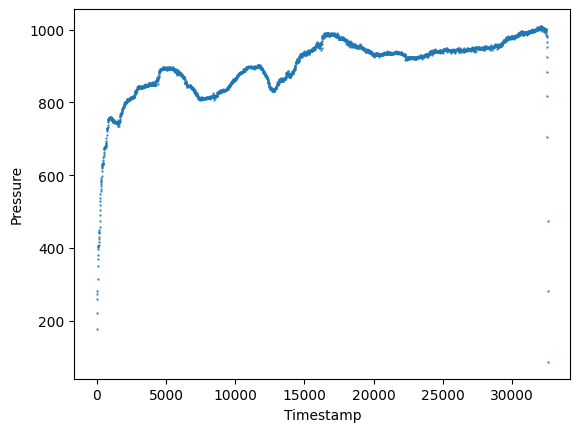

In [33]:
plot(f=parkinson_file_list[1],  plot_func=sns.regplot, t_id=0, x='Timestamp', y='Pressure')

{'Precision': 0.5, 'Recall': 1.0, 'F1': 0.6666666666666666}


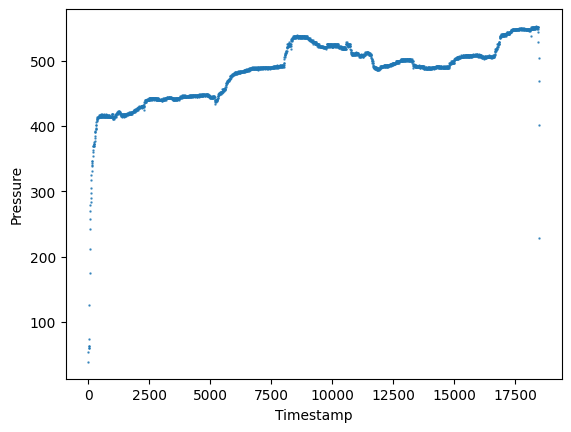

In [34]:
plot(control_file_list[1], plot_func=sns.regplot, t_id=0, x='Timestamp', y='Pressure')

{'Precision': 0.5, 'Recall': 1.0, 'F1': 0.6666666666666666}


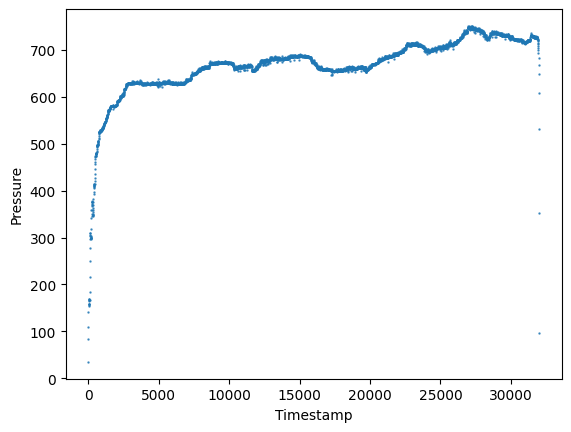

In [35]:
plot(f=parkinson_file_list[35],  plot_func=sns.regplot, t_id=0, x='Timestamp', y='Pressure')

{'Precision': 0.5, 'Recall': 1.0, 'F1': 0.6666666666666666}


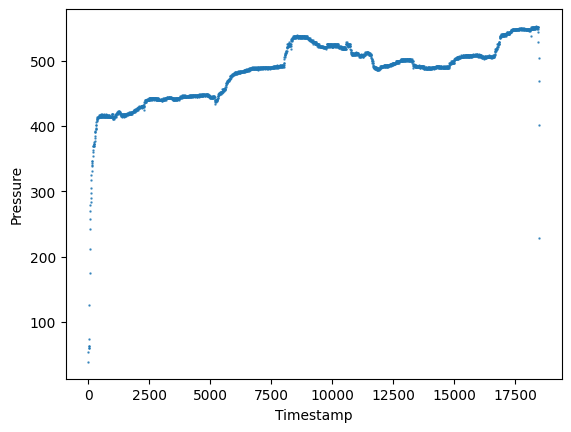

In [36]:
plot(control_file_list[1], plot_func=sns.regplot, t_id=0, x='Timestamp', y='Pressure')